In [1]:
!pip install scikit-learn
!pip install networkx
!pip install joblib
!pip install scipy
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install pandas
!pip install tqdm igraph

In [99]:
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from joblib import Parallel, delayed
import os

import dag_utils as utils
from baselines import Nonneg_dagma, MetMulDagma
from TopoGreedy import TopoGreedy, TopoGreedy_sk
from baselines import colide_ev
from baselines import DAGMA_linear
from baselines import notears_linear


PATH = './results/samples/'
SAVE = True 
SEED = 10
N_CPUS = os.cpu_count()  # Get number of available CPUs
np.random.seed(SEED)

In [107]:
# Experiment function
def get_lamb_value(n_nodes, n_samples, times=1):
    return np.sqrt(np.log(n_nodes) / n_samples) * times 

def run_samples_exp(g, data_p, N_samples, exps, thr=.2, verb=False):
    shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Theta_est = [np.zeros((len(N_samples), len(exps)))  for _ in range(9)]
    for i, n_samples in enumerate(N_samples):
        if g % N_CPUS == 0:
            print(f'Graph: {g+1}, samples: {n_samples}')

        # Create data
        data_p_aux = data_p.copy()
        data_p_aux['n_samples'] = n_samples

        W_true, _, X, Theta_true = utils.simulate_sem(**data_p_aux)
        X_std = utils.standarize(X)
        W_true_bin = utils.to_bin(W_true, thr)
        norm_W_true = np.linalg.norm(W_true)

        for j, exp in enumerate(exps):
            X_aux = X_std if 'standarize' in exp.keys() and exp['standarize'] else X


            arg_aux = exp['args'].copy()
            if 'adapt_lamb' in exp.keys() and exp['adapt_lamb']:
                if 'lamb' in arg_aux.keys():
                    arg_aux['lamb'] = get_lamb_value(data_p['n_nodes'], n_samples, arg_aux['lamb'])
                elif 'lambda1' in arg_aux.keys():
                    arg_aux['lambda1'] = get_lamb_value(data_p['n_nodes'], n_samples, arg_aux['lambda1'])

            if exp['model'] == notears_linear:
                t_init = perf_counter()
                W_est = notears_linear(X_aux, **arg_aux)
                t_end = perf_counter()

            
            else:

                model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
                t_init = perf_counter()
                model.fit(X_aux, **arg_aux)
                t_end = perf_counter()
                W_est = model.W_est
                Theta_est = model.Theta_est
                

            if np.isnan(W_est).any():
                W_est = np.zeros_like(W_est)
                W_est_bin = np.zeros_like(W_est)
            else:
                W_est_bin = utils.to_bin(W_est, thr)
            
            W_est_bin = W_est_bin.T if exp['model'] == TopoGreedy else W_est_bin
            W_est = W_est.T if exp['model'] == TopoGreedy else W_est


            shd[i,j], tpr[i,j], fdr[i,j] = utils.count_accuracy(W_true_bin, W_est_bin)
            fscore[i,j] = f1_score(W_true_bin.flatten(), W_est_bin.flatten())
            err[i,j] = utils.compute_norm_sq_err(W_true, W_est, norm_W_true)
            acyc[i,j] = model.dagness(W_est) if hasattr(model, 'dagness') else 1
            Theta_est[i,j] = np.linalg.norm(Theta_est - Theta_true, 'fro') / (np.linalg.norm(Theta_true, 'fro') + 1e-8)
            runtime[i,j] = t_end - t_init
            dag_count[i,j] += 1 if utils.is_dag(W_est_bin) else 0
        
            if verb and (g % N_CPUS == 0):

                print(f'-{exp["leg"]}: shd {shd[i,j]}  -  err: {err[i,j]}  -  Theta diff: {Theta_est[i,j]:.3f}  -  time: {runtime[i,j]:.3f}')

    return shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Theta_est

In [108]:
n_dags = 160
N_samples = [1000,2000,4000,5000,6000,8000,10000]

# DEFINE EXPERIMENTS
Exps = [
  # TopoGreedy with more iterations but looser tolerance
  {'model': TopoGreedy, 'args': {'max_iter': 4000, 'tol': 1e-4}, 'fmt': '^-', 'leg': 'Topo4000-1e-4'},
]

In [109]:
N = 100
thr = .2
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (0.5, 1.5),
    'var': 1,
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Theta_est =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(9)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Theta_est = zip(*results)

CPUs employed: 8
Graph: 1, samples: 1000
-Topo4000-1e-4: shd 388.0  -  err: 1.530138960702258  -  Theta diff: 0.217  -  time: 17.767
Graph: 1, samples: 2000
-Topo4000-1e-4: shd 79.0  -  err: 0.14930989914285464  -  Theta diff: 0.143  -  time: 18.335
Graph: 1, samples: 4000
-Topo4000-1e-4: shd 140.0  -  err: 0.5821555528657438  -  Theta diff: 0.096  -  time: 17.942
Graph: 1, samples: 5000


KeyboardInterrupt: 

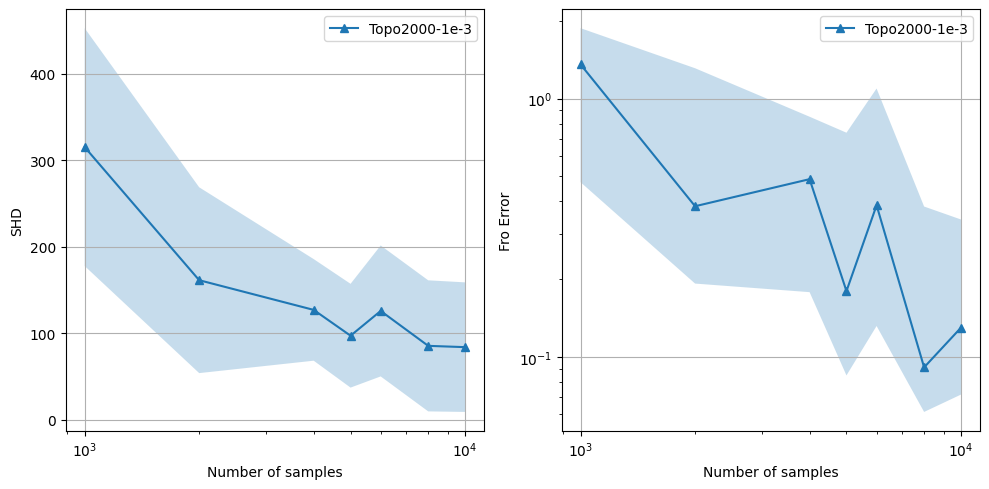

In [86]:
# if SAVE:
#     import os
#     os.makedirs(PATH, exist_ok=True)
#     file_name = PATH + f'samples_{N}N_{int(data_p["edges"]/N)}'
#     np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
#              acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
#              xvals=N_samples)
#     print('SAVED in file:', file_name)

#     agg_error = np.median(err, axis=0)
#     utils.data_to_csv(f'{PATH}samples_err_med.csv', Exps, N_samples, agg_error)
#     prctile25 = np.percentile(err, 25, axis=0)
#     utils.data_to_csv(f'{PATH}samples_err_prctile25.csv', Exps, N_samples, prctile25)
#     prctile75 = np.percentile(err, 75, axis=0)
#     utils.data_to_csv(f'{PATH}samples_err_prctile75.csv', Exps, N_samples, prctile75)

#     agg_shd = np.mean(err, axis=0)
#     utils.data_to_csv(f'{PATH}samples_shd_mean.csv', Exps, N_samples, agg_shd)
#     std_shd = np.std(err, axis=0)
#     utils.data_to_csv(f'{PATH}samples_shd_std.csv', Exps, N_samples, std_shd)

skip = []

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
utils.plot_data(axes[0], shd, Exps, N_samples, 'Number of samples', 'SHD', skip,
                agg='mean', deviation='std', alpha=0.25)
utils.plot_data(axes[1], err, Exps, N_samples, 'Number of samples', 'Fro Error', skip,
                agg='median', deviation='prctile', alpha=0.25, plot_func='loglog')
plt.tight_layout()
plt.savefig(PATH + f'samples_{N}N_{int(data_p["edges"]/N)}.png', dpi=300, bbox_inches='tight')